In [263]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 16 14:01:03 2024

@author: hssdwo
"""
import sys, os
sys.path.append(os.path.join(sys.path[0], '..'))

import os
import imageio.v3 as iio
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import cv2
from skimage.morphology import closing, black_tophat
from scipy.stats import mode
from sklearn.neighbors import KernelDensity

from image_cleaning import get_rotation_angle
# For automatic digitisation tools to work, we need to clean up the initial image in stages:
# 1. rotate image (note that this can be applied to image, or to the extracted signal at the end)
# 2. de-shadow image
# 3. identify the 12 lead labels, and segment the image into the 12 leads

In [264]:
def std_rescale(image, contrast=1):
    """
    Standardizes to between [-contrast, contrast] regardless of range of input
    """
    ptp_ratio = contrast/np.ptp(image)
    shift = (np.max(image) + np.min(image))/contrast # works with negative values
    return ptp_ratio*(image - shift)

def norm_rescale(image, contrast=1):
    """
    Normalizes to zero mean and scales to have one of (abs(max), abs(min)) = contrast
    """
    scale = np.max(np.abs([np.max(image), np.min(image)]))
    return contrast*(image - np.mean(image))/scale

def zero_one_rescale(image):
    """
    Rescales to between 0 and 1
    """
    return (image - np.min(image))/np.ptp(image)

def sigmoid(x):
    """
    tanh sigmoid function
    """
    return 1./(1. + np.exp(-x))
    

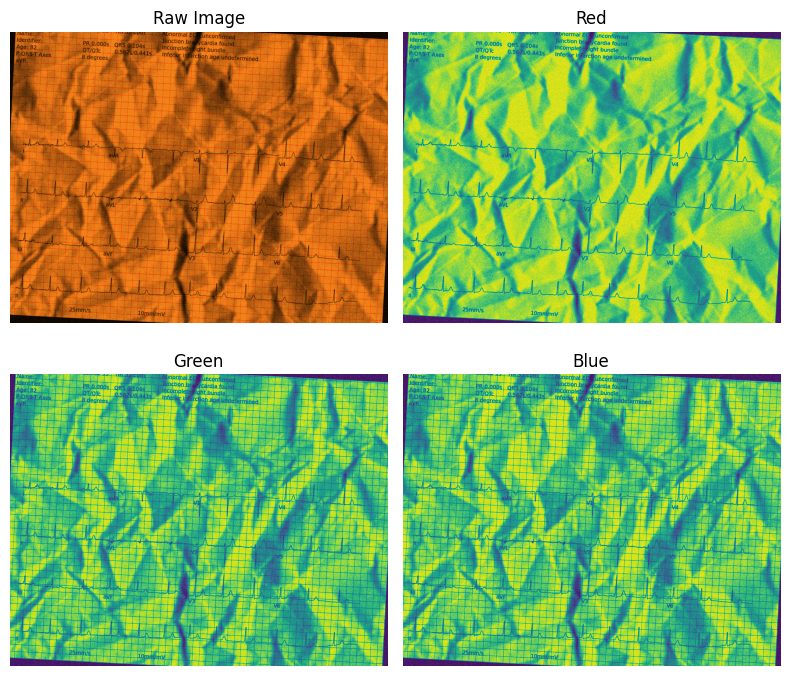

In [265]:
# ---- import image from folder ------
# im = iio.imread(os.path.join('..', 'tiny_testset', 'records500', '00001_hr-0.png'))
# im = iio.imread(os.path.join('..', 'tiny_testset', 'records500', '00003_hr-0.png'))
im = iio.imread(os.path.join('..', 'tiny_testset', 'records500', '00021_hr-0.png'))
# im = iio.imread('D:\\Downloads\\test.png') # 500hz_00000_sample/00099_hr-0.png


# files are png, in RGBa format. The alpha channel is 255 for all pixels (opaque) and therefore
# totally uniformative. Let's remove it
im = np.delete(im, np.s_[-1:], axis=2)

# plot to view the raw image, and the RGB channels individually
# by default is uint8, convert to float to avoid overflow
red_im = im[:,:,0].astype(np.float32)
green_im = im[:,:,1].astype(np.float32)
blue_im =  im[:,:,2].astype(np.float32)

fig, axs = plt.subplots(2,2)
# remove tickers from axes
for ax in axs.flatten():
    ax.axis('off')
# set figure size 
fig.set_size_inches(8, 7)
# tight layout
plt.tight_layout()
axs[0,0].title.set_text('Raw Image')
axs[0,0].imshow(im)
axs[0,1].title.set_text('Red')
axs[0,1].imshow(red_im)
axs[1,0].title.set_text('Green')
axs[1,0].imshow(green_im) 
axs[1,1].title.set_text('Blue')
axs[1,1].imshow(blue_im)
plt.show()


In [266]:
# get rotation angle
rot_angle = get_rotation_angle(blue_im, red_im)

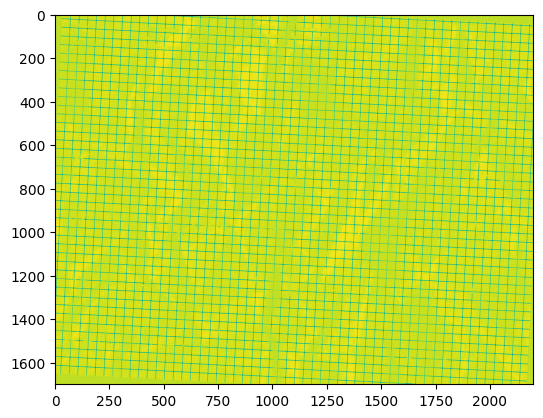

In [267]:
## ---- process the image to enhance the grid and get rid of shadows
# this seems to work because the grid lines are usually not visible in red channel - SS
# todo - fix magic number here
scale = np.mean(blue_im)/np.mean(red_im)
dev_im = blue_im - (red_im*scale) # scaled red image so that it is the same brightness. Hard_coded for now
plt.figure()
plt.imshow(dev_im)


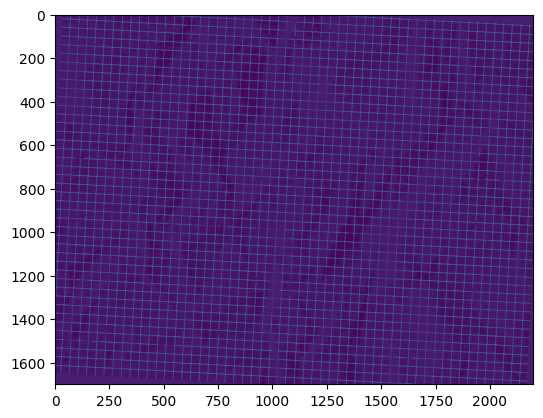

In [268]:
grid = blue_im - (red_im*scale) # save this for later

# grid = grid - np.min(grid)
# this is crazy sensitive, wild really
# grid_mode_adjusted = sp.stats.mode(grid, axis=None)[0] - 10
# grid[grid<grid_mode_adjusted] = 0
# grid[grid>grid_mode_adjusted] = 255
grid_filter = sigmoid(std_rescale(-grid))
plt.figure()
plt.imshow(grid_filter)

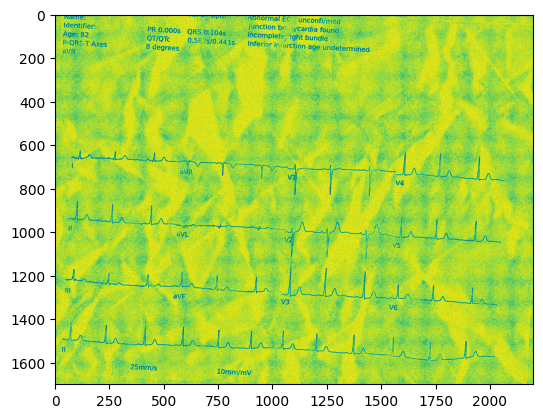

In [269]:
# morphological filter on red channel? (closing?)
footprint = 8
test = closing(red_im, footprint=[(np.ones((footprint, 1)), 1), (np.ones((1, footprint)), 1)])

output_im = red_im - test
plt.figure()
plt.imshow(output_im)

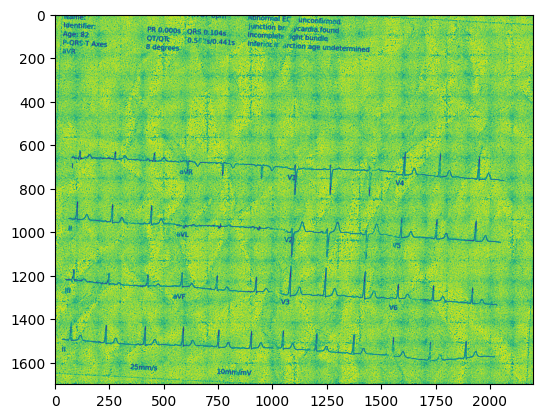

In [270]:
# darken the 9.2% darkest pixels
# THIS ONLY WORKS FOR 8 BIT UNSIGNED INTS BTW
output_im_8bit = output_im.copy().astype(np.uint8)
vals = output_im_8bit.flatten()
b = np.histogram(vals,255) # puts into bins of pixel values
a = np.cumsum(b[0]) # cumulative sum of number of pixels ? like a gradient
c = a[-1]*0.092 # find smallest 9.2% 
# thresh = np.argmax(a[a<345260])
if a[0] > c:
    print('no pixels below threshold')
    thresh = 255*0.092
else:
    thresh = np.argmax(a[a<c])

output_im_8bit[output_im_8bit<thresh] = 0 # need to figure out this magic number
plt.figure()
plt.imshow(output_im_8bit)

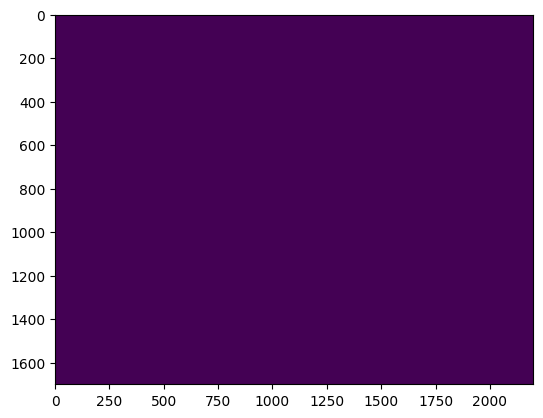

In [271]:
# showing that it breaks completely if dtype is float32
output_im_float = output_im.copy().astype(np.float32)
vals = output_im_float.flatten()
b = np.histogram(vals,255) # puts into bins of pixel values
a = np.cumsum(b[0]) # cumulative sum of number of pixels ? like a gradient
c = a[-1]*0.092 # find smallest 9.2% 
# thresh = np.argmax(a[a<345260])
if a[0] > c:
    print('no pixels below threshold')
    thresh = 255*0.092
else:
    thresh = np.argmax(a[a<c])

output_im_float[output_im_float<thresh] = 0 # need to figure out this magic number
plt.figure()
plt.imshow(output_im_float)

0.0
-255.0


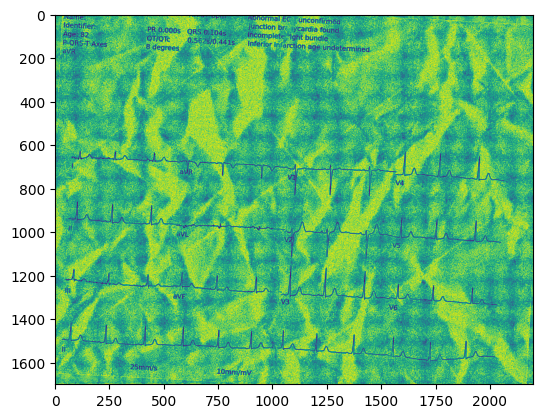

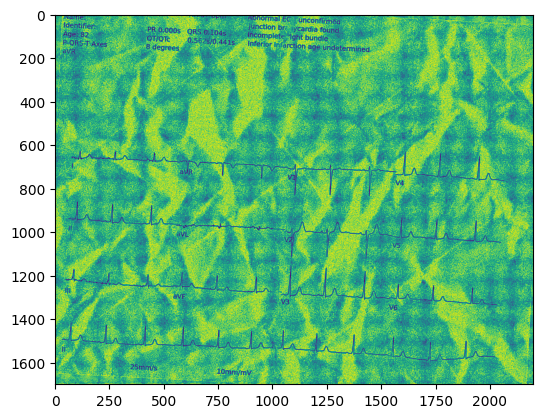

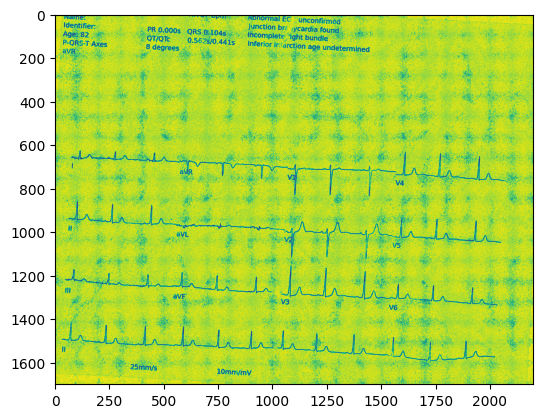

In [272]:
# Alternately, try applying a sigmoid to the image

# normalize to have 0 mean and values between -1 and 1
# contrast is a magic number here, tanh caps out around -4ish
print(output_im.max())
print(output_im.min())
sigmoid_norm = 255*sigmoid(norm_rescale(output_im, contrast=8))
sigmoid_std = 255*sigmoid(std_rescale(output_im, contrast=8))

# feel like we can combine these somehow to be useful?
combo = sigmoid_norm - sigmoid_std


plt.figure()
plt.imshow(sigmoid_norm)
plt.figure()
plt.imshow(sigmoid_std)
plt.figure()
plt.imshow(combo)

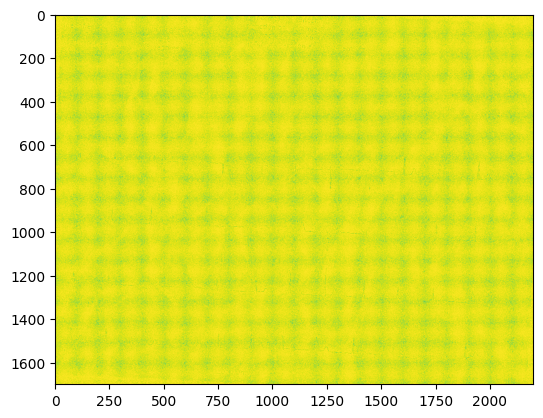

In [273]:
# try to remove morph filter artifacts
footprint = 2
test0 = closing(red_im, footprint=[(np.ones((footprint, 1)), 1), (np.ones((1, footprint)), 1)])

output_im0 = red_im - test0
plt.figure()
plt.imshow(output_im0)

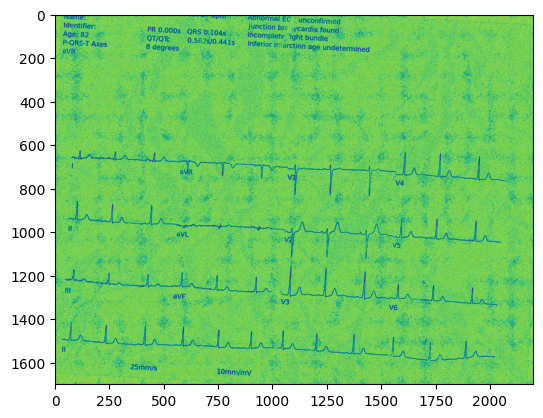

In [274]:
filter2 = zero_one_rescale(output_im0)
scale = np.mean(combo)/np.mean(filter2)
combo2 = combo - (filter2*scale)
plt.figure()
plt.imshow(combo2)

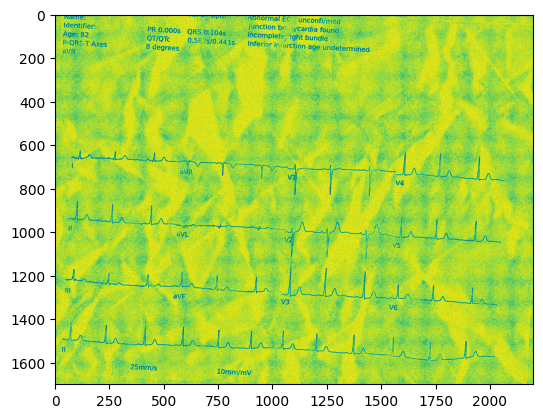

In [275]:
# apply rotation
plt.figure()
plt.imshow(output_im)

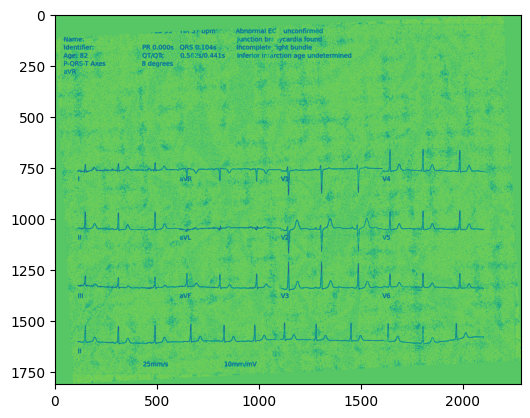

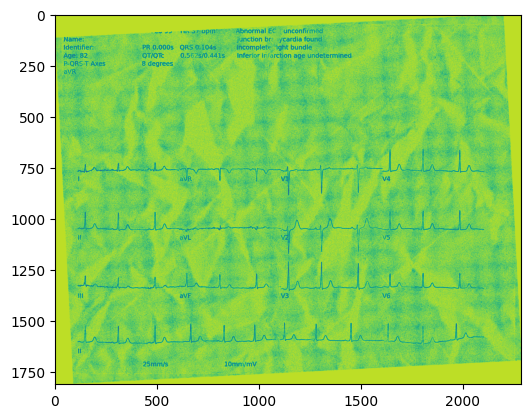

In [276]:
# rotated images
plt.figure()
plt.imshow(sp.ndimage.rotate(combo2, rot_angle, axes=(1, 0), reshape=True))
output_rot = sp.ndimage.rotate(output_im, rot_angle, axes=(1, 0), reshape=True)
plt.figure()
plt.imshow(output_rot)